In [30]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

## load path
import os
import sys
sys.path.append('../')
sys.path.append('../models')
from pathlib import Path

## load utils 
from util.util import *
from util.true_gaussian_process_seq import *
from util.ofm_OT_likelihood_seq_mino import *
import statsmodels.api as sm
from scipy.stats import binned_statistic
import matplotlib.tri as tri
from util.metrics import *
import time

## load modules 
from models.mino_unet import MINO
from models.mino_modules.decoder_perceiver import DecoderPerceiver
from models.mino_modules.encoder_supernodes_gno_cross_attention import EncoderSupernodes
from models.mino_modules.conditioner_timestep import ConditionerTimestep

from models.mino_modules.modules.unet_nD import UNetModelWrapper

In [2]:
query_dims = [16, 16]
x_dim = 2

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
spath = Path('./saved_models/MINO_U_Cylinder')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# GP hyperparameters
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default

# model hyperparameters
## conditional time step.. 
dim = 256
num_heads=4

## u-net parameters
unet_dims = (dim, 16, 16)
unet_channels = 64
num_res_blocks=1
num_unet_heads=8
attention_res = '8'

## training parameters
epochs = 300
sigma_min=1e-4 
batch_size = 96

In [3]:
# [batch_size, n_chan, n_seq]
# pos_data [bathc_size, x_dim, n_seq]
x_train = np.load('../dataset/cylinder/x_train.npy')
x_train = torch.Tensor(x_train).permute(0, 2, 1)

n_pos = np.load('../dataset/cylinder/pos_normalized.npy')
n_pos = torch.Tensor(n_pos)
pos_data = n_pos.unsqueeze(0).repeat(len(x_train), 1, 1).permute(0, 2, 1)

query_pos = make_2d_grid(query_dims).permute(1,0) #[2, 16x16]
train_dataset = SimDataset(x_train, pos_data, query_pos)

loader_tr =  DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=SimulationCollator,
)

## Model Initialization

In [ ]:
conditioner = ConditionerTimestep(
    dim=dim
)
model = MINO(
    conditioner=conditioner,
    encoder=EncoderSupernodes(
        input_dim=3, # co-domain 
        ndim=2, # dimension of domain
        radius= 0.07,
        enc_dim=dim,
        enc_num_heads=num_heads,
        enc_depth=2,
        cond_dim=conditioner.cond_dim,
    ),
    
    processor=UNetModelWrapper(dim=unet_dims, num_channels=unet_channels,
                                          num_res_blocks=num_res_blocks,
                                          num_heads=num_unet_heads, set_cond=False,
                                          attention_resolutions=attention_res),
    
    decoder=DecoderPerceiver(
        input_dim=dim,
        output_dim=3,
        ndim=2,
        dim=dim,
        num_heads=num_heads,
        depth=2, # 2 layers
        unbatch_mode="dense_to_sparse_unpadded",
        cond_dim=conditioner.cond_dim,
    ),
)
model = model.to(device)
#print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")



In [13]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)
fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, x_dim=x_dim, n_pos=n_pos)


In [ ]:
fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(300), generate=False, save_path=spath,saved_model=saved_model)


## Evaluation

In [48]:
# load the trained model
for param in model.parameters():
    param.requires_grad = False
    
model_path = os.path.join(spath, 'epoch_300.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
model.load_state_dict(checkpoint, strict=False)
fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, x_dim=x_dim, n_pos=n_pos)


In [49]:
def gen_meta_info(batch_size, query_dims, n_pos=n_pos):
 
    pos_data = n_pos.unsqueeze(0).repeat(batch_size, 1, 1)
    
    query_n_pos = make_2d_grid(query_dims)
    query_pos_data = query_n_pos.unsqueeze(0).repeat(batch_size, 1, 1)

    collated_batch = {}


    collated_batch["input_pos"] = pos_data.permute(0, 2, 1)
    collated_batch['query_pos']= query_pos_data.permute(0, 2, 1)


    return collated_batch

In [50]:
start = time.time()

In [51]:
with torch.no_grad():

    X_alt = []
    for i in range(25):
        collated_batch =  gen_meta_info(batch_size=100, n_pos=n_pos, query_dims=query_dims)
        pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos']
        X_temp = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=200, n_channels=3, n_eval=2).cpu()
    
        #X_temp = fmot.sample(pos=pos_data[:200].to(device), n_samples=200, n_eval=10).cpu()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt).squeeze()

In [ ]:
end = time.time()
print(end-start)

## Metric

In [53]:
x_test =  np.load('../dataset/cylinder/x_test.npy')
x_test = torch.Tensor(x_test[:5000]).permute(0,2,1)

In [54]:
swd_value = swd_stable(X=X_alt, Y=x_test)

In [55]:
mmd_value = unbiased_mmd2_torch(X=X_alt, Y=x_test, device=device)  

## visualization

In [41]:
def random_index(data, ratio, replace=False, seed=None):

    if seed is not None:
        np.random.seed(seed)

    L = data.shape[-1]
    k = int(ratio * L)
    idx = np.random.choice(L, size=k, replace=replace)
    
    return idx

def plot_cyl(x, y, field_val, vmin=None, vmax=None, save_fig=False, input_text='v1', random_subsample=False, subsample_ratio=1):
    
    if random_subsample is True:
        idx = random_index(field_val, subsample_ratio)
        x = x[idx]
        y = y[idx]
        field_val = field_val[idx]
        
    triang = tri.Triangulation(x, y)

    circles = [
        ((0, 0), 0.515),
    ]

    mask = np.zeros(triang.triangles.shape[0], dtype=bool)
    for i, tri_inds in enumerate(triang.triangles):
        # Get centroid of this triangle
        x_c = x[tri_inds].mean()
        y_c = y[tri_inds].mean()
        # Check if centroid is in any of the circles
        for (cx, cy), r in circles:
            if (x_c - cx)**2 + (y_c - cy)**2 < r**2:
                mask[i] = True
                break

    triang.set_mask(mask)

    fig, ax = plt.subplots(figsize=(6, 5))

                          # wireframe
    tcf = ax.tricontourf(triang, field_val, levels=50, cmap='jet', extend='max', vmin=vmin, vmax=vmax)  # filled field
    ax.triplot(triang, lw=0.1, c='k')   
    #fig.colorbar(tcf, ax=ax, label='Field value')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    
    if save_fig is True:
        plt.savefig('./plot_results/cylinder_{}.pdf'.format(input_text))

In [42]:
## sub generation
pos_idx = random_index(n_pos.transpose(1,0), ratio=1)
pos_down = n_pos[pos_idx]

with torch.no_grad():

    collated_batch =  gen_meta_info(batch_size=10, n_pos=pos_down, query_dims=query_dims)
    pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos']

    X_hat = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=10, n_eval=5, n_channels=3, return_path=False).cpu()
    #X_hat = X_hat.reshape(X_hat.shape[0], *dims)

In [46]:
x_temp = X_hat[8]
x_pos_raw_down, y_pos_raw_down = pos_down[:,0]*8-1, pos_down[:,1]*4-2 # unnormalized
plot_cyl(x_pos_raw_down, y_pos_raw_down, x_temp[0].numpy())

## super-resolution

In [103]:
import numpy as np
from scipy.spatial import Delaunay

def refine_mesh(points, k=2):
    """
    Parameters
    ----------
    points : (N, 2) ndarray
        Original 2‑D coordinates (need not be ordered).
    k : int >= 1
        Subdivision factor per edge.  k=1 → no refinement.

    Returns
    -------
    pts_new : (N1, 2) ndarray
        Refined set of vertices (superset of the originals).
    """
    points = np.asarray(points, dtype=float)
    if k < 1 or int(k) != k:
        raise ValueError("k must be a positive integer")

    # 1. Delaunay triangulation
    tri = Delaunay(points)

    # 2. Pre‑compute barycentric coordinates of subdivision lattice
    #    for one reference triangle
    #    u, v, w are barycentric and satisfy u + v + w = 1, u,v,w >= 0
    lattice = []
    for i in range(k + 1):
        for j in range(k + 1 - i):
            lattice.append((i / k, j / k, 1 - (i + j) / k))
    bary = np.stack(lattice, axis=0)          # shape (K, 3)
    K = bary.shape[0]                         # points per refined triangle

    # 3. Generate refined points for every original triangle
    pts_refined = []
    for simplex in tri.simplices:             # 3 indices of this triangle
        verts = points[simplex]               # shape (3, 2)
        # affine combination: u*v0 + v*v1 + w*v2
        pts_refined.append(bary @ verts)      # (K, 2)

    pts_refined = np.vstack(pts_refined)

    # 4. Deduplicate (shared edges → duplicate points)
    #    tolerance ~ 1e‑12 relative to bounding box diagonal
    eps = 1e-12 * np.linalg.norm(points.ptp(axis=0))
    _, idx = np.unique(np.round(pts_refined / eps).astype(np.int64),
                       axis=0, return_index=True)
    pts_unique = pts_refined[idx]

    return pts_unique



In [119]:
def reject_cycle(pos_new, hole_center=(0., 0.), hole_radius=0.515):
    hole_radius2 = hole_radius**2
    accepted = []
    pos_x, pos_y = pos_new[:,0] * 8 - 1, pos_new[:,1]*4-2
    xs = pos_x
    ys = pos_y
    dx = xs - hole_center[0]
    dy = ys - hole_center[1]
    mask = dx*dx + dy*dy >= hole_radius2

    accepted.extend(np.column_stack((pos_new[mask, 0] , pos_new[mask,1])))
    return np.asarray(accepted)

In [120]:
pos_new = refine_mesh(n_pos, k=2)

pos_new = reject_cycle(pos_new)

new_pos = torch.Tensor(pos_new)

In [124]:
with torch.no_grad():

    collated_batch =  gen_meta_info(batch_size=10, n_pos=new_pos, query_dims=query_dims)
    pos, query_pos = collated_batch['input_pos'], collated_batch['query_pos']
    #X_hat = sample(fmot, pos=pos.to(device), query_pos=query_pos.to(device), n_samples=10, n_eval=10).cpu()
    X_hat = fmot.sample(pos=pos.to(device), query_pos=query_pos.to(device), n_samples=10, n_eval=10, n_channels=3).cpu()
    #X_hat = X_hat.reshape(X_hat.shape[0], *dims)

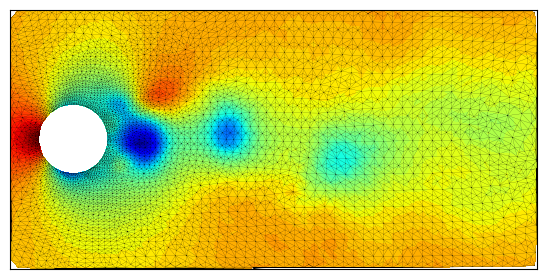

In [133]:
x_pos_new, y_pos_new = new_pos[:,0]*8-1, new_pos[:,1]*4-2
plot_cyl(x_pos_new, y_pos_new , X_hat[4,2].numpy())